#### Carry out Tree based feature selection, feature selection with the Genetic Algorithm and LOSO with a random forest classifier

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from parameter_feature_search import *
import glob
import time
import pandas as pd
from plotting_tools import plot_feature_distributions
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import DataProcess as DP
warnings.filterwarnings("ignore")
%matplotlib inline

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### We can choose to use just the protocol or just the optional datset

In [2]:
protocol_datadir = '/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/'
optional_datadir = '/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Optional/'

In [3]:
allfiles = list(glob.glob(protocol_datadir+'*.dat'))+list(glob.glob(optional_datadir+'*.dat'))

all_dfs = []
for fname in allfiles:
    print(fname)
    subject_index = int(fname.split('/')[-1].split('.')[0][-1])
    dp = DP.dataprocess(fname,T=512,stride=512)
    
    #For LOSO, we need subjectID in the final dataframe
    dp.df['subjectID'] = int(subject_index)*np.ones(len(dp.df))
    all_dfs.append(dp.df)
    
feature_df = pd.concat(all_dfs)

/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/subject101.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/subject107.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/subject105.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/subject106.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/subject103.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/subject109.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/subject104.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/subject102.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Protocol/subject108.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Optional/subject101.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Optional/subject105.dat
/home/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_Dataset/Optional/subject106.dat
/home/rmartinsho

In [5]:
feature_df.to_csv("Features_df_with_subject.dat",index=False)

#### Load features dataframe

In [2]:
feature_df = pd.read_csv("Features_df_with_subject.dat")

In [3]:
Y = feature_df['activityID']
X = feature_df.drop(['activityID','subjectID'],axis=1)

#### Scale the input matrix and generate classification labels from the target column

In [4]:
sc = StandardScaler()
X_scaled = pd.DataFrame(sc.fit_transform(X),columns=X.columns)
le = LabelEncoder()
labels = le.fit_transform(Y)

#### Set up inputs for initial hyperparameter search function

In [5]:
model = RandomForestClassifier()

parameters = {
    'classify__n_estimators': (85,95,100,105),
    'classify__max_depth': (10,20,30,50,None),
    'classify__class_weight':("balanced","balanced_subsample",None),
    'classify__criterion':('gini','entropy')
}

#### Select optimal hyperparemeters and an estimate of the best feature columns

In [ ]:
X_new, best_classifier = test_model_initial(model,X_scaled,labels,parameters)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (85, 95, 100, 105), 'classify__max_depth': (10, 20, 30, 50, None), 'classify__class_weight': ('balanced', 'balanced_subsample', None), 'classify__criterion': ('gini', 'entropy')}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min


In [11]:
len(X_new.columns)

96

#### Find the best classifier without selecting feature columns

#### Select optimal feature columns using genetic algorithm

In [25]:
t1 = time.time()
GA = Run_GA(X_scaled,labels,best_classifier)
t2 = time.time()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

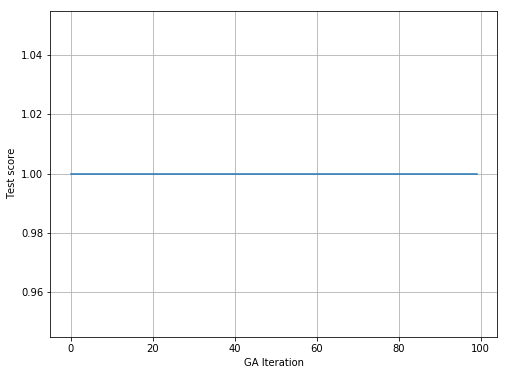

In [14]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(GA.fitness_evolution)
ax.set_xlabel('GA Iteration')
ax.set_ylabel('Test score')
plt.grid()

In [12]:
GA.best_fitness

NameError: name 'GA' is not defined

In [16]:
len(GA.feature_selection.columns)

102

#### Do LOSO on the original feature columns 

In [13]:
X_features = X

sc = StandardScaler()
X_features_scaled = pd.DataFrame(sc.fit_transform(X_features),columns=X_features.columns)
X_features_scaled['activityID'] = feature_df['activityID'].values
X_features_scaled['subjectID'] = feature_df['subjectID'].values

In [14]:
subject_scores_no_selection = LOSO(X_features_scaled,best_classifier)

Holding out subject 6
----------------------------------------------------
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        28
        2.0       0.24      1.00      0.38        24
        3.0       0.74      0.65      0.69        26
        4.0       1.00      0.93      0.96        27
        5.0       1.00      1.00      1.00        25
        6.0       1.00      1.00      1.00        26
        7.0       0.97      1.00      0.99        36
       10.0       0.33      0.03      0.05        79
       12.0       0.69      1.00      0.82         9
       13.0       1.00      1.00      1.00         9
       16.0       0.69      0.92      0.79        26
       17.0       0.59      0.94      0.72        50
       18.0       0.00      0.00      0.00        29
       19.0       0.88      0.56      0.69        39

avg / total       0.67      0.68      0.63       433

----------------------------------------------------
Holding out subject 8

In [15]:
subject_scores_no_selection

{'1.0': 0.4036850921273032,
 '2.0': 0.9297124600638977,
 '3.0': 0.7475728155339806,
 '4.0': 0.924187725631769,
 '5.0': 0.7755905511811023,
 '6.0': 0.6789838337182448,
 '7.0': 0.9368421052631579,
 '8.0': 0.6706114398422091,
 '9.0': 0.5898617511520737}

In [22]:
mean_LOSO_no_selection = np.mean([subject_scores_no_selection[e] for e in list(subject_scores_no_selection.keys())])

#### Do LOSO on the feature columns selected by the GA

In [22]:
new_features_GA = list(GA.feature_columns) + ['activityID','subjectID']
X_feature_select_GA = feature_df[new_features_GA]

sc = StandardScaler()
X_feature_select_GA_scaled = pd.DataFrame(sc.fit_transform(X_feature_select_GA),columns=X_feature_select_GA.columns)
X_feature_select_GA_scaled['activityID'] = X_feature_select_GA['activityID'].values
X_feature_select_GA_scaled['subjectID'] = X_feature_select_GA['subjectID'].values

In [23]:
subject_scores_GA_selection = LOSO(X_feature_select_GA_scaled,best_classifier)

Holding out subject 1
Holding out subject 6
Holding out subject 5
Holding out subject 8
Holding out subject 9


In [24]:
subject_scores_GA_selection

{'1.0': 0.2048611111111111,
 '5.0': 0.9606741573033708,
 '6.0': 0.8266666666666667,
 '8.0': 0.7849462365591398,
 '9.0': 0.9619047619047619}

In [25]:
mean_LOSO_GA = np.mean([subject_scores_GA_selection[e] for e in list(subject_scores_GA_selection.keys())])

#### Do LOSO on the feature columns selected by the tree-based proceedure

In [16]:
new_features_Treebased = list(X_new.columns) + ['activityID','subjectID']
X_feature_select_Treebased = feature_df[new_features_Treebased]

sc = StandardScaler()
X_feature_select_Treebased_scaled = pd.DataFrame(sc.fit_transform(X_feature_select_Treebased),columns=X_feature_select_Treebased.columns)
X_feature_select_Treebased_scaled['activityID'] = X_feature_select_Treebased['activityID']
X_feature_select_Treebased_scaled['subjectID'] = X_feature_select_Treebased['subjectID']

In [17]:
subject_scores_Treebased_selection = LOSO(X_feature_select_Treebased,best_classifier)

Holding out subject 8
----------------------------------------------------
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        36
        2.0       0.83      1.00      0.91        29
        3.0       0.37      0.97      0.53        33
        4.0       0.98      1.00      0.99        44
        5.0       0.66      1.00      0.79        21
        6.0       0.97      1.00      0.98        31
        7.0       1.00      1.00      1.00        39
       10.0       1.00      0.36      0.53        89
       12.0       0.75      1.00      0.86         9
       13.0       0.70      1.00      0.82         7
       16.0       0.91      0.97      0.94        33
       17.0       0.49      1.00      0.66        43
       18.0       0.00      0.00      0.00        29
       19.0       0.90      0.55      0.68        51
       20.0       0.00      0.00      0.00        20
       24.0       1.00      1.00      1.00         7

avg / total       0.77

In [18]:
subject_scores_Treebased_selection

{'1.0': 0.3996447602131439,
 '2.0': 0.9272727272727272,
 '3.0': 0.6700507614213198,
 '4.0': 0.9661654135338346,
 '5.0': 0.8619329388560157,
 '6.0': 0.6914660831509847,
 '7.0': 0.8915254237288136,
 '8.0': 0.7485604606525912,
 '9.0': 0.5700483091787439}

In [19]:
mean_LOSO_Treebased = np.mean([subject_scores_Treebased_selection[e] for e in list(subject_scores_Treebased_selection.keys())])

#### Compare final scores

In [23]:
print('Mean LOSO score for tree-based selection: %0.3f' %mean_LOSO_Treebased)
#print('Mean LOSO score for GA-based selection: %0.3f' %mean_LOSO_GA)
print('Mean LOSO score for no feature selection: %0.3f' %mean_LOSO_no_selection)

Mean LOSO score for tree-based selection: 0.747
Mean LOSO score for no feature selection: 0.740


Conclusion: LOSO is a tough problem. Optimal selection of feature columns doesn't make much difference to the result